In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import sparse

from pynufft import NUFFT_cpu

import pylops

$\left[ \left(\tilde{f_{\Re}}^T \tilde{f_{\Re}} + \tilde{f_{\Im}}^T \tilde{f_{\Im}} \right) + R^T R \right] x = \tilde{f_{\Re}}^T y_{\Re} + \tilde{f_{\Im}}^T y_{\Im}$

# Pylops

In [2]:
def NormalEquationsInversion(
    Op, 
    data, 
    WOp=None,
    HOp=None,
    returninfo=False, 
    **kwargs_cg
):

    OpH = Op.H

    if WOp is not None:
        Op_normal = OpH * WOp * Op
    else:
        Op_normal = OpH * Op
    
    if HOp is not None:
        Op_normal += HOp

    if WOp is not None:
        y_normal = OpH * WOp * data
    else:
        y_normal = OpH * data

    xinv, istop = sparse.linalg.cg(Op_normal, y_normal, **kwargs_cg)

    if returninfo:
        return xinv, istop
    else:
        return xinv

## Operators

In [3]:
class D_Op(NUFFT_cpu, pylops.LinearOperator):
    def __init__(self, uv, shape_2d, reshaping_x=True):
        super(D_Op, self).__init__()

        self.u, self.v = uv.T

        om = np.array([self.u, self.v]).T
        
        self.shape_2d = shape_2d

        self.plan(
            om=om,
            Nd=self.shape_2d,
            Kd=(
                int(2 * self.shape_2d[0]),
                int(2 * self.shape_2d[1])
            ),
            Jd=(6, 6),
        )

        n_p = int(self.shape_2d[0] * self.shape_2d[1])

        self.shape = (uv.shape[0], n_p)
        self.dtype = "complex128"
        self.explicit = False
        
        self.reshaping_x = reshaping_x
        
    def reshape_x(self, x):
        return x.reshape(self.shape_2d)

    def forward_lop(self, x):
        if self.reshaping_x:
            x = self.reshape_x(x=x)
            
        y = self.k2y(self.xx2k(self.x2xx(x)))

        return y

    def adjoint_lop(self, y):

        x = self.xx2x(self.k2xx(self.y2k(y)))

        return x

    def _matvec(self, x):
        return self.forward_lop(x)

    def _rmatvec(self, x):
        return self.adjoint_lop(x)

In [4]:
class H_Op(pylops.LinearOperator):
    def __init__(self, h, dtype="float64"):

        self.h = h
        self.pixels = h.shape[0]
        self.dims = self.pixels
        self.shape = (self.pixels, self.pixels)
        self.dtype = dtype
        self.explicit = False

    def _matvec(self, x):
        return np.dot(self.h, x)

    def _rmatvec(self, x):
        return np.dot(self.h.T, x)

# Tools

In [5]:
def a_complex_from_a_real_and_a_imag(
    a_real, 
    a_imag
):
    # NOTE: Convert a numpy array of shape (n, 2) to a complex array of shape (n, )

    a_complex = np.stack(
        arrays=(a_real, a_imag), axis=-1
    )

    a_complex = np.apply_along_axis(
        lambda args: [complex(*args)], len(a_complex.shape) - 1, a_complex
    ).astype("complex128")

    return np.squeeze(a_complex)

In [6]:
# NOTE: Make a "random" sparse matrix (with 0's & 1's)
def random_sparse_matrix(n_p, n_s):

    def nonzero_to_ones(a):

        a[np.where(a > 0.0)] = 1.0

        return a

    f_obj = sparse.random(
        m=n_p, n=n_s
    )

    return nonzero_to_ones(
        a=f_obj.A
    )

# Examples

In [7]:
def x_for_MF(Dop, f, d_real, d_imag, WOp=None, HOp=None):

    f_tilde = np.zeros(
        shape=(Dop.shape[0], f.shape[-1]), dtype="complex"
    )
    for i in range(f_tilde.shape[-1]):
        f_tilde[:, i] = Dop.forward_lop(x=f[:, i])

    f_tilde_real = f_tilde.real
    f_tilde_imag = f_tilde.imag
    
    if WOp is not None:
        W = WOp.todense()
    else:
        W = np.diag(
            np.ones(shape=(Dop.shape[0]))
        )
        
    F_real = np.dot(np.dot(f_tilde_real.T, W), f_tilde_real)
    F_imag = np.dot(np.dot(f_tilde_imag.T, W), f_tilde_imag)

    D_real = np.dot(np.dot(f_tilde_real.T, W), d_real)
    D_imag = np.dot(np.dot(f_tilde_imag.T, W), d_imag)

    F = F_real + F_imag
    D = D_real + D_imag

    if HOp is not None:
        H = HOp.todense()

        x = np.linalg.solve(F + H, D)
    else:
        x = np.linalg.solve(F, D)

    return x


def x_for_PF(Dop, f, d_real, d_imag, WOp=None, HOp=None):

    f_lops = pylops.MatrixMult(
        sparse.bsr_matrix(f), dtype='float64'
    )

    Op = Dop * f_lops

    # NOTE:
    Op = Op.toreal(
        forw=False, adj=True
    )

    data = a_complex_from_a_real_and_a_imag(
        a_real=d_real, a_imag=d_imag
    )

    x = NormalEquationsInversion(
        Op=Op,
        data=data,
        WOp=WOp,
        HOp=HOp
    )

    return x

In [8]:
# NOTE: n_v is the # of visibilities
n_v = 100 

# NOTE: Non-uniform points in the uv-space
u = np.random.uniform(-1.0, 1.0, n_v)
v = np.random.uniform(-1.0, 1.0, n_v)
uv = np.stack(arrays=(u, v), axis=-1)

# NOTE: n_s is the # of source-plane pixels
n_s = 20

# NOTE: 
shape_2d = (20, 20)

# NOTE: n_p is the # of image-plane pixels
n_p = int(shape_2d[0] * shape_2d[1]) 

# NOTE: 
f = random_sparse_matrix(
    n_p=n_p, n_s=n_s
)

# NOTE
Dop = D_Op(uv=uv, shape_2d=shape_2d)

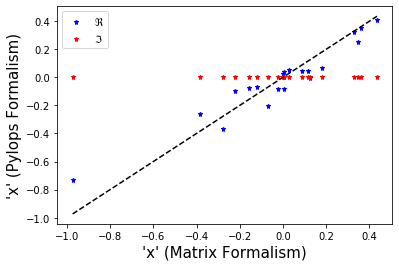

In [10]:
regularization = True

if regularization:
    h_coeff = 1.0
    h = h_coeff * np.diag(np.ones(n_s, ))

    HOp = H_Op(h=h, dtype="float64")
    
    # NOTE: This does not fix things ...
    #HOp = HOp.toreal(forw=False, adj=True)
else:
    HOp = None

y_real = np.random.normal(0.0, 1.0, size=(n_v, ))
y_imag = np.random.normal(0.0, 1.0, size=(n_v, ))

# NOTE:
sigma = abs(
    np.random.normal(0.0, 1.0, size=(n_v, ))
)
weights = 1.0 / sigma**2.0

WOp = pylops.Diagonal(diag=weights, dtype="float64")

_x_for_MF = x_for_MF(
    Dop=Dop,
    f=f,
    d_real=y_real,
    d_imag=y_imag,
    WOp=WOp,
    HOp=HOp
)
_x_for_PF = x_for_PF(
    Dop=Dop,
    f=f,
    d_real=y_real,
    d_imag=y_imag,
    WOp=WOp,
    HOp=HOp
)


# NOTE: We want the solution \'x\' to be real (or equivalently the imag 
# component of the solution to be zero). This is what we get.
plt.figure()
plt.plot(_x_for_MF, _x_for_PF.real, linestyle="None", marker="*", markersize=5, color="b", label=r"$\Re$")
plt.plot(_x_for_MF, _x_for_PF.imag, linestyle="None", marker="*", markersize=5, color="r", label=r"$\Im$")
plt.legend()

x_min = np.min(_x_for_MF)
x_max = np.max(_x_for_MF)
plt.plot(
    np.linspace(x_min, x_max, 10),
    np.linspace(x_min, x_max, 10),
    linestyle="--",
    color="black"
)

plt.xlabel("\'x\' (Matrix Formalism)", fontsize=15)
plt.ylabel("\'x\' (Pylops Formalism)", fontsize=15)

plt.show()